# **OneVsRest - Logistic Regression**

<font size="+2" color="black"><b> OneVsRest </b></font><br><a id="1"></a>

**Let’s talk about what is OneVsRest and why is it useful for multi-label classification tasks?**
* OVR as it’s known is a very intuitive approach for solving multi-label classifications tasks in which the problem is decomposed into multiple binary classification problems, in which the labels should be mutually exclusive of each other.
* In OVR, we pick one class and train a binary classifier with the samples of the selected class on one side and all the other samples on the other side. Thus, we end up with N classifiers for N labels. While testing, we simply classify the sample as belonging to the class with the maximum score among the N classifiers. Let’s understand this with a simple example
* Let’s assume that one comment has 3 label — “obscene”, “insult”, “identity hate”. While training or testing the model, the OVR will work like this — is the label “obscene” or not? Is the label “insult”  or not? Is the label “identity hate”  or not? Here, we have broken down the multi-label problem into three binary classification problems. At the end of the training phase, we will combine the outputs of these three binary classification problems into one single output. Thus, it’s all about fitting one classifier per class. For each classifier, the class is fitted against all the other classes.



<font size="+2" color="black"><b> Prepare the Data </b></font><br><a id="1"></a>

In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
import re
import string
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from scipy.sparse import hstack

#Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import log_loss, roc_auc_score,roc_curve,auc,confusion_matrix

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
target = train[labels].astype(np.int8)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
appo = {
"aren't" : "are not",
"can't" : "can not",
"couldn't" : "could not",
"didn't" : "did not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "i would",
"i'd" : "i had",
"i'll" : "i will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't" : "was not",
"we'll" : " will",
"tryin'" : "trying",
"yay!" : " good ",
"yay" : " good ",
"yaay" : " good ",
"yaaay" : " good ",
"yaaaay" : " good ",
"yaaaaay" : " good ",
":/" : " bad ",
":&gt;" : " sad ",
":')" : " sad ",
":-(" : " frown ",
":(" : " frown ",
":s": " frown ",
":-s": " frown ",
"&lt;3": " heart ",
":d": " smile ",
":p": " smile ",
":dd": " smile ",
"8)": " smile ",
":-)": " smile ",
":)": " smile ",
";)": " smile ",
"(-:": " smile ",
"(:": " smile ",
":/": " worry ",
":&gt;": " angry ",
":')": " sad ",
":-(": " sad ",
":(": " sad ",
":s": " sad ",
":-s": " sad ",
r"\br\b": "are",
r"\bu\b": "you",
r"\bhaha\b": "ha",
r"\bhahaha\b": "ha",
r"\bdon't\b": "do not",
r"\bdoesn't\b": "does not",
r"\bdidn't\b": "did not",
r"\bhasn't\b": "has not",
r"\bhaven't\b": "have not",
r"\bhadn't\b": "had not",
r"\bwon't\b": "will not",
r"\bwouldn't\b": "would not",
r"\bcan't\b": "can not",
r"\bcannot\b": "can not",
r"\bi'm\b": "i am",
"m": "am",
"r": "are",
"u": "you",
"haha": "ha",
"hahaha": "ha",
"doesn't": "does not",
"cannot": "can not",
"its" : "it is",
"'s" : " is",
"d'aww!":"cute"
}

In [ ]:
keys = [i for i in appo.keys()]

new_train_data = []
ltr = train["comment_text"].tolist()
for i in ltr:
    arr = str(i).split()
    xx = ""
    for j in arr:
        j = str(j).lower()
        if j[:4] == 'http' or j[:3] == 'www':
            continue
        if j in keys:
            # print("inn")
            j = appo[j]
        xx += j + " "
    new_train_data.append(xx)

train["comment_text"] = new_train_data

In [ ]:
new_test_data = []
lte = test["comment_text"].tolist()

for i in lte:
    arr = str(i).split()
    xx = ""
    for j in arr:
        j = str(j).lower()
        if j[:4] == 'http' or j[:3] == 'www':
            continue
        if j in keys:
            # print("inn")
            j = appo[j]
        xx += j + " "
    new_test_data.append(xx)

test["comment_text"] = new_test_data


In [ ]:
trate = train["comment_text"].tolist()
tete = test["comment_text"].tolist()

In [ ]:
for i, c in enumerate(trate):
    trate[i] = re.sub('[^a-zA-Z ?!]+', '', str(trate[i]).lower())
    trate[i] = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",trate[i]) #remove ip
    trate[i] = re.sub("\[\[.*\]","",trate[i]) #remove user_name
for i, c in enumerate(tete):
    tete[i] = re.sub('[^a-zA-Z ?!]+', '', tete[i])
    tete[i] = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",tete[i])
    tete[i] = re.sub("\[\[.*\]","",tete[i])
train["comment_text"] = trate
test["comment_text"] = tete
del(trate)
del(tete)

<font size="+2" color="black"><b> Featurizations for Machine Learning model </b></font><br><a id="1"></a>

* I tried word based TF-IDF unigrams, and character based TF-IDF 2 to 6-grams. In case of word unigrams, we will just take into consideration one single word at each time for building TF-IDF vectors. But with using unigrams we can not capture the sequence information. It'S the major drawback. For capturing the sequence information, we may use bigrams, tri-grams etc.


* In case of char n-grams we simply consider individual or sequence of characters rather than sequence of words. For this case study character n-gram features worked well.

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
train_word_features = word_vectorizer.fit_transform(train['comment_text'])
test_word_features = word_vectorizer.transform(test['comment_text'])

In [ ]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
train_char_features = char_vectorizer.fit_transform(train['comment_text'])
test_char_features = char_vectorizer.transform(test['comment_text'])

In [ ]:
train_features = hstack([train_char_features, train_word_features]).tocsr()
test_features = hstack([test_char_features, test_word_features]).tocsr()

In [ ]:
del(train_char_features)
del(test_char_features)
del(train_word_features)
del(test_word_features)

In [ ]:
del(train)
del(test)

<font size="+2" color="black"><b> Hyper Parameter Tuning </b></font><br><a id="1"></a>

Now I decide to do grid search to seek for the "optimal" hyperparameters for the baseline model that I've chose. Since there is 6 different lables, tuning models for each label would be time expensive, so I will use the most common label "Toxic" to tune hyperparameters.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_features, target, test_size=0.2, random_state=0)

In [ ]:
logistic_regression_classifier = LogisticRegression()

parameter_grid = {'C':[0.01,0.1,0.25,0.5,1],
                  'solver' : ['lbfgs', 'newton-cg'],
                  'fit_intercept' : [True,False],
                  'penalty'       : ['l1', 'l2'],
                  'class_weight'  : [None, 'balanced']}

cross_validation = StratifiedKFold(n_splits=3)

grid_search = GridSearchCV(logistic_regression_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='roc_auc')

grid_search.fit(X_train, y_train['toxic'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best parameters: {'C': 1, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'lbfgs'}


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**The ROC curves for our baseline model’s performance on each toxicity type as classified by our baseline model.**

CV score for class toxic is 0.9771289513607931
CV score for class severe_toxic is 0.9881334536260106
CV score for class obscene is 0.989830668082381
CV score for class threat is 0.9894840635726038
CV score for class insult is 0.9825558121209713
CV score for class identity_hate is 0.9824200619741305


Text(0.5, 1.0, 'Receiver Operating Characteristic Curve')

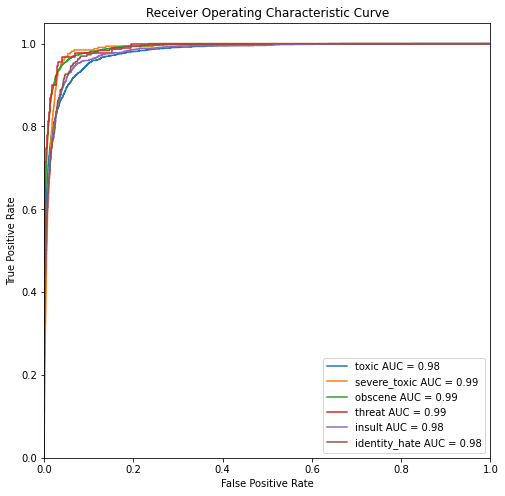

In [ ]:
scores = []
d = {k:[] for k in y_test.columns.tolist()}
plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
avg_auc = 0
for class_ in labels:
    logR = OneVsRestClassifier(LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                                                  intercept_scaling=1, l1_ratio=None, max_iter=100,
                                                  multi_class='auto', n_jobs=None, penalty='l2',
                                                  random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                                                  warm_start=False), n_jobs=-1)

    cv_score = np.mean(cross_val_score(logR, X_train, y_train[class_], cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_, cv_score))

    logR.fit(X_train, y_train[class_])
    prediction = logR.predict_proba(X_test)
    actual = y_test[class_]
    fpr, tpr, threshold = roc_curve(actual,prediction[:,1])
    d[class_] = d[class_] + np.where(prediction[:,1]>=threshold[np.argmax(tpr-fpr)],1,0).tolist()
    AUC = np.round(roc_auc_score(actual,prediction[:,1]),2)
    avg_auc = avg_auc + AUC
    plt.plot(fpr,tpr,label=class_+" AUC = "+str(AUC))
    plt.legend(loc="lower right")
plt.title('Receiver Operating Characteristic Curve')

With this baseline model, we found relatively good performance as measured by the ROC curves for each toxicity type.


We will train our model with 3 fold cross-validation. We will compute ROC-AUC score for all toxicity labels and for all folds. After tha, we will take the average score of all 3 folds.

In [ ]:
folds = 3
scores = []
scores_classes = np.zeros((len(labels), folds))

submission = pd.DataFrame.from_dict({'id': test['id']})
kf = KFold(n_splits=folds, shuffle=True, random_state=239)

for j, (class_name) in enumerate(labels):
#    train_target = train[class_name]

    classifier = classifier = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                                                                intercept_scaling=1, l1_ratio=None, max_iter=100,
                                                               multi_class='auto', n_jobs=None, penalty='l2',
                                                               random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                                                               warm_start=False), n_jobs=-1)) ])

    avreal = target[class_name]
    lr_cv_sum = 0
    lr_pred = []
    lr_fpred = []
    lr_avpred = np.zeros(train.shape[0])


    for i, (train_index, val_index) in enumerate(kf.split(train_features)):
        X_train, X_val = train_features[train_index], train_features[val_index]
        y_train, y_val = target.loc[train_index], target.loc[val_index]

        classifier.fit(X_train, y_train[class_name])
        scores_val = classifier.predict_proba(X_val)[:, 1]
        lr_avpred[val_index] = scores_val
        lr_y_pred = classifier.predict_proba(test_features)[:, 1]
        scores_classes[j][i] = roc_auc_score(y_val[class_name], scores_val)
        print('\n Fold %02d class %s AUC: %.6f' % ((i+1), class_name, scores_classes[j][i]))

        if i > 0:
            lr_fpred = lr_pred + lr_y_pred
        else:
            lr_fpred = lr_y_pred

        lr_pred = lr_fpred

    lr_cv_score = (lr_cv_sum / folds)
    lr_oof_auc = roc_auc_score(avreal, lr_avpred)
    print('\n Average class %s AUC:\t%.6f' % (class_name, np.mean(scores_classes[j])))
    print(' Out-of-fold class %s AUC:\t%.6f' % (class_name, lr_oof_auc))


    submission[class_name] = lr_pred / folds


print('\n Overall AUC:\t%.6f' % (np.mean(scores_classes)))




 Fold 01 class toxic AUC: 0.978600

 Fold 02 class toxic AUC: 0.977350

 Fold 03 class toxic AUC: 0.977662

 Average class toxic AUC:	0.977871
 Out-of-fold class toxic AUC:	0.977867

 Fold 01 class severe_toxic AUC: 0.987930

 Fold 02 class severe_toxic AUC: 0.988125

 Fold 03 class severe_toxic AUC: 0.988631

 Average class severe_toxic AUC:	0.988229
 Out-of-fold class severe_toxic AUC:	0.988234

 Fold 01 class obscene AUC: 0.989774

 Fold 02 class obscene AUC: 0.989429

 Fold 03 class obscene AUC: 0.990390

 Average class obscene AUC:	0.989864
 Out-of-fold class obscene AUC:	0.989865

 Fold 01 class threat AUC: 0.988658

 Fold 02 class threat AUC: 0.989017

 Fold 03 class threat AUC: 0.991512

 Average class threat AUC:	0.989729
 Out-of-fold class threat AUC:	0.989693

 Fold 01 class insult AUC: 0.981374

 Fold 02 class insult AUC: 0.982588

 Fold 03 class insult AUC: 0.982532

 Average class insult AUC:	0.982165
 Out-of-fold class insult AUC:	0.982161

 Fold 01 class identity_hate 

In [ ]:
submission.to_csv('submission-OvsR-LR.csv', index=False)


The mean ROC AUC across the 6 labels on the blind test set private score was **0.98019** and public score was **0.97961**, which is good performance for a baseline.

Since the number of true negatives (non-toxic comments) in our dataset is large and ROC curves plot the true positive rate (TPR = TP/(TP + FN)) vs. the false positive rate (FPR = FP/(FP + TN)), their appearance is biased by this imbalance in our dataset. However, since the mean AUC for these ROC curves was the official metric of the Kaggle challenge, I used it as my primary evaulation metric.

ovsr.PNG